In [1]:
import matplotlib.pyplot as plt
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

# Week 11, ASTR 596: Fundamentals of Data Science


## Forests and Networks

### Gautham Narayan, Konstantin Malanchev
##### <gsn@illinois.edu>

# Recap

### Terminology

- Supervised learning - function approximation
  * Classification vs regression
  * Train, validation, test data sets
- Unsupervised learning - distribution approximation
  * Clustering vs dimensionality reeduction vs **anomaly detection**
- Loss function


### Decision trees

- Unbalanced binary trees
- Split criteria: select axis split value minimizing impurity
- Impurity measure $G$ is based on criteria $H$: $G = \frac{n_{left}}{n} H({y}_{left}) + \frac{n_{right}}{n} H({y}_{right})$
  * Classification: Shennon entropy $-p_i \log_2{p_i}$ and Gini coefficient $p_i (1 - p_i)$
  * Regression: inter-partition $\sum |y_i - \overline{y}|$ (L1) and $\sum (y_i - \overline{y})^2$ (L2)
  * **NB:** these split criteria depend only on $y$, not on $x$
- Hyperparameters:
  * Maximum depth
  * Shrinkage (pre-pruning) condition, e.g. minimum impurity change

# Let's build a decision tree for ELAsTiCC SN classification

<!--
clf = DecisionTreeClassifier(max_depth=6, criterion='entropy', random_state=0)
clf.fit(X_train, y_train)
-->

In [2]:
# RUN THIS

%matplotlib inline
import graphviz
import numpy as np
import pandas as pd
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics, model_selection, preprocessing

In [3]:
# RUN THIS

# Read in the data
df = pd.read_csv('elasticc.csv.bz2')
# Here we have some features extracted from light curves in LSST ri passbands
# and features of potential host galaxies
display(df)

# Let SN Type Ia to be a positive class, and SN Type II to be a negative class
y = df.pop('type') == 'Ia'
# We removed type from the data frame, so X is just df
X = df

# Split into training and test sets, 70/30
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=1, shuffle=True,
)

,mag_anderson_darling_normal_lsstr,mag_bins_window1.0_offset0.0_beyond_1_std_lsstr,mag_bins_window1.0_offset0.0_beyond_2_std_lsstr,mag_bins_window1.0_offset0.0_eta_e_lsstr,mag_bins_window1.0_offset0.0_kurtosis_lsstr,mag_bins_window1.0_offset0.0_linear_trend_lsstr,mag_bins_window1.0_offset0.0_linear_trend_sigma_lsstr,mag_bins_window1.0_offset0.0_linear_trend_noise_lsstr,mag_bins_window1.0_offset0.0_maximum_slope_lsstr,mag_bins_window1.0_offset0.0_minimum_time_interval_lsstr,...,fullflux_bazin_fit_reduced_chi2_lssti,fullflux_villar_fit_amplitude_lssti,fullflux_villar_fit_baseline_lssti,fullflux_villar_fit_reference_time_lssti,fullflux_villar_fit_rise_time_lssti,fullflux_villar_fit_fall_time_lssti,fullflux_villar_fit_plateau_rel_amplitude_lssti,fullflux_villar_fit_plateau_duration_lssti,fullflux_villar_fit_reduced_chi2_lssti,type
0,0.780511,0.375000,0.0,0.741684,-1.769079,0.029526,0.007275,0.584790,0.163100,3.0,...,1.769251,356.349370,2.222196,1236.56970,3.061274,56.395218,0.823527,39.350754,1.493443,Ia
1,0.473129,0.250000,0.0,1.387581,-0.973231,0.006783,0.005083,0.527309,0.050394,3.0,...,1.840118,480.798250,-35.533897,1187.08480,1.556034,455.316300,0.850162,82.269090,1.783804,Ia
2,0.695245,0.250000,0.0,0.423260,-2.209777,0.027511,0.006806,0.489444,0.073121,2.0,...,0.959707,256.736760,-44.886124,1114.65260,53.186268,69.696976,0.261479,5.661001,2.072954,Ia
3,0.838607,0.200000,0.0,0.204319,-0.679639,0.023742,0.013548,0.681058,0.098864,1.0,...,1.622323,412.242500,-2.058283,1128.73340,3.449223,38.205635,0.528041,27.685513,1.899322,Ia
4,0.502514,0.461538,0.0,0.327310,-1.474365,0.026306,0.002906,0.426057,0.176273,1.0,...,4.882568,1521.277000,-12.103599,1039.79650,0.855270,35.321354,0.346311,45.250020,6.618827,Ia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10704,0.740410,0.250000,0.0,0.352083,-2.282112,0.021526,0.001993,0.135682,0.077744,1.0,...,1.620303,245.655880,-1.393047,328.52030,4.390476,63.614550,0.641911,2.186191,1.415801,II
10705,0.325791,0.363636,0.0,1.964222,-1.114480,0.024174,0.001231,0.117965,0.339445,1.0,...,4.575971,205.707870,-0.687885,508.17548,2.035590,17.735273,0.628592,90.014220,1.786174,II
10706,0.314148,0.500000,0.0,0.584003,-1.785932,0.027058,0.004449,0.287560,0.100499,2.0,...,1.259199,123.428505,-0.497189,577.03960,4.247261,57.356080,0.470965,39.387234,1.331100,II
10707,0.924880,0.500000,0.0,0.445454,-2.265188,0.036624,0.003092,0.216344,0.238676,1.0,...,0.919468,277.172150,-4.181707,1095.16550,0.171585,88.188530,0.740799,66.439330,0.759697,II


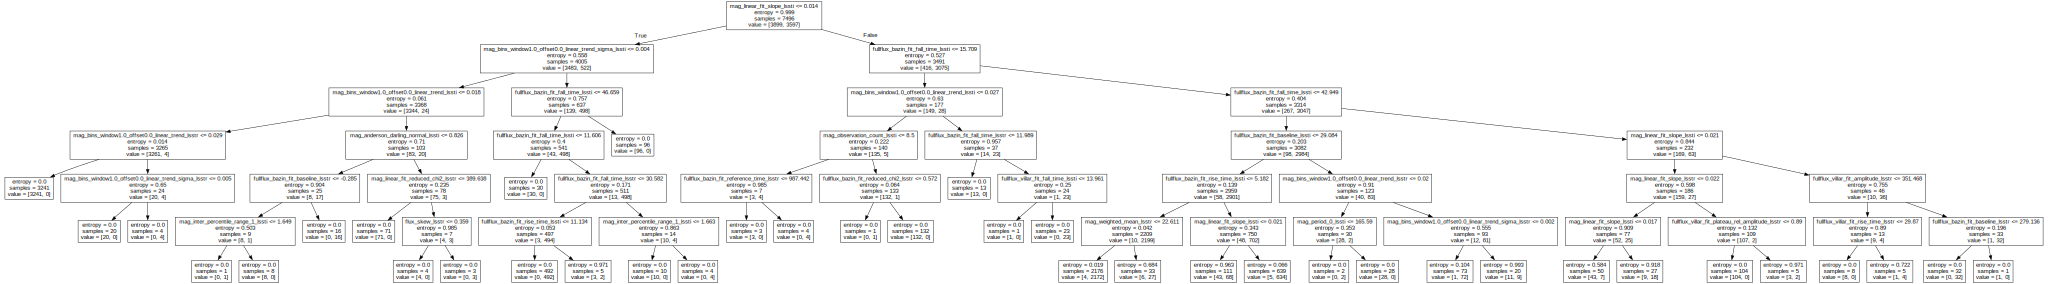

Accuracy train: 0.9881270010672358
Log-loss train: 0.42794625822190874
Accuracy test: 0.9803921568627451
Log-loss test: 0.7067383017473954


In [4]:
# TWO LINES OF CODE TO IMPLEMENT A DECISION TREE

# | put your hyperparameters here
# |
# V
clf = DecisionTreeClassifier(max_depth=6, criterion='entropy', random_state=1)
clf.fit(X_train, y_train)

# Plot the Tree
dot_data = sklearn.tree.export_graphviz(clf, feature_names=X.columns, out_file=None) 
graph = graphviz.Source(dot_data)
display(graph)

print('Accuracy train:', metrics.accuracy_score(y_train, clf.predict(X_train)))
print('Log-loss train:', metrics.log_loss(y_train, clf.predict(X_train)))
print('Accuracy test:', metrics.accuracy_score(y_test, clf.predict(X_test)))
print('Log-loss test:', metrics.log_loss(y_test, clf.predict(X_test)))

## The big issues with trees

* Variance - different data lead to different trees
    - intuitively if you have just two continuous variables, then calculating the split for every node even with a depth = 2 tree is of order $\infty^2$
    
You can view each tree as a single path that you can take do get the desired outcome.

There are many possible paths, so we do the thing we always do and marginalize over them.

In other words, go from a single decision tree to a many decision trees.

## Ensemble Methods: Bagging

Run multiple different models on the same data and learn from the ensemble

We can improve the performance of decisions trees (especially when there are many features) by **bagging** (Bootstrap AGGregation). This averages the predictive results of a series of bootstrap samples.

For a sample of $N$ points in a training set, bagging generates $K$ equally sized bootstrap samples from which to estimate the function $f_i(x)$. The final estimator, defined by bagging, is then

\begin{equation}
\huge
f(x)=\frac{1}{K} \sum_{i}^{K} f_{i}(x)
\end{equation}


(Yep, this is just take the average of all the individual methods)

# Can Random Forest beat a single tree?

<!--
clf = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=14, random_state=0, n_jobs=4)
clf.fit(X_train, y_train)
-->

In [5]:
%%time

# TWO LINES OF CODE TO IMPLEMENT A RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, max_depth=14, random_state=0, n_jobs=4)
clf.fit(X_train, y_train)

print('Accuracy train:', metrics.accuracy_score(y_train, clf.predict(X_train)))
print('Log-loss train:', metrics.log_loss(y_train, clf.predict(X_train)))
print('Accuracy test:', metrics.accuracy_score(y_test, clf.predict(X_test)))
print('Log-loss test:', metrics.log_loss(y_test, clf.predict(X_test)))

Accuracy train: 0.9997331910352187
Log-loss train: 0.009616769847683561
Accuracy test: 0.9940865234982882
Log-loss test: 0.2131432973523892
CPU times: user 29.2 s, sys: 465 ms, total: 29.7 s
Wall time: 7.66 s


## Ensemble Methods: Boosting

Boosting is an ensemble approach motivated by the idea that combining many weak classifiers can result in an improved classification. 

Boosting creates models to attempt to correct the errors of the ensemble so far 
**i.e. we reweight the data based on how incorrectly the data were classified in the previous iteration.**

- if you have $N$ data points in your sample with features $x$, and target $y$

\begin{equation}
\large
x_{i} \in \mathbb{R}^{d}, y_{i} \in\{-1,1\}
\end{equation}
**initalize the weights to $1/N$**

- Run the classification $h$ (i.e. hypotheses) with a weak clasifier $t$ times and compute the weighted classification error for each classifier

\begin{equation}
\large
\epsilon = \frac{\sum_{i=1}^{N} w_{i} I\left(y_{i} \neq h_{j}\left(x_{i}\right)\right)}{\sum_{i=1}^{N} w_{i}}
\end{equation}

where $I$ is the indicator variable (1 if $y_i$ matches the hypotheses, 0 if not).

- The weight for each weak classifier is related to the weighted classification error

\begin{equation}
\large
\theta_{t}=\frac{1}{2} \ln \left(\frac{1-\epsilon_{t}}{\epsilon_{t}}\right)
\end{equation}

- each time reweight each sample $i$ based on the previous performance of the classifier $t$

For any classifier with accuracy higher than 50%, the weight is positive. 
The more accurate the classifier, the larger the weight.
For a classifer with less than 50% accuracy, the weight is negative.

\begin{equation}
\large
w_{t+1}=\frac{w_{t} \exp \left[-\theta_{t} y_{i} h_{t} \right]}{Z_{t}}
\end{equation}
        
Where the denominator is the normalization constant to make the sum of the weights 1. 

If a misclassified case is from a positive weighted classifier, the “exp” term in the numerator would be always larger than 1. 

**NOTE THAT A WEAK CLASSIFIER WITH A NEGATIVE WEIGHT STILL CONTRIBUTES**
(you can be wrong, but if you are wrong consistently, then you are still useful)

You can view this as just iteratively minimizing the exponential loss function

\begin{equation}
\large
L(y, F(x))=E\left(e^{-y F(x)}\right)
\end{equation}

where $E$ is just weighted expectation value.

[I'll spare you the math](https://web.archive.org/web/20190418150438/https://towardsdatascience.com/boosting-algorithm-adaboost-b6737a9ee60c)

- At the end of this procedure we allow the classifiers a weighted vote on the final classification

\begin{equation}
\large
H(x)=\operatorname{sign}\left(\sum_{t=1}^{T} \theta_{t} h_{t}(x)\right)
\end{equation}

    
The most popular form of boosting is that of adaptive boosting (helpfully implemented in a package called **AdaBoost**)

A fundamental limitation of the boosted decision tree is the computation time for large data sets (they rely on a chain of classifiers).

Boosting can be thought of as a function decomposition into trees, similar to the Taylor series. Through an iterative process, each new tree's output is subtracted from the true value of $y$, with the goal of minimizing residuals with each subsequent tree.

\begin{equation}
\large
y_{true} = \theta_1 h_1(x) + \theta_2 h_2(x) + \dots
\end{equation}

# The textbook has a couple of examples of using Random Forests and BDTs for regression using SDSS galaxies with known redshifts (the target) and magnitudes as features - i.e. a photo-z estimator.

@pickle_results: using precomputed results from 'photoz_forest.pkl'


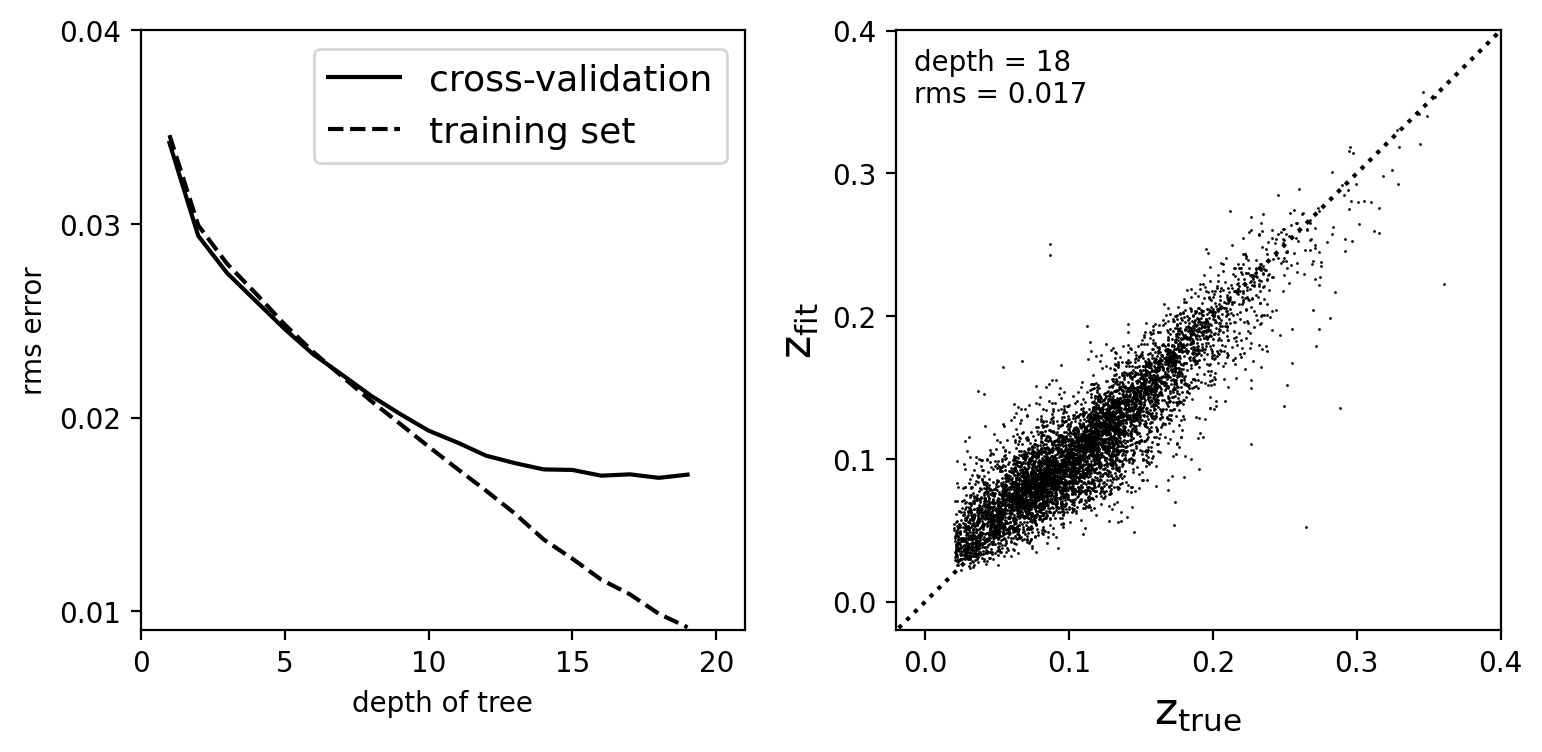

CPU times: user 2.56 s, sys: 1.42 s, total: 3.98 s
Wall time: 2.23 s


In [6]:
%%time

import numpy as np
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from astroML.datasets import fetch_sdss_specgals
from astroML.utils import pickle_results

#------------------------------------------------------------
# Fetch and prepare the data
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

# test on ~6,000 distinct points
mag_test = mag[1::100]
z_test = z[1::100]


#------------------------------------------------------------
# Compute the results
#  This is a long computation, so we'll save the results to a pickle.
@pickle_results('photoz_forest.pkl')
def compute_photoz_forest(depth):
    rms_test = np.zeros(len(depth))
    rms_train = np.zeros(len(depth))
    i_best = 0
    z_fit_best = None

    for i, d in enumerate(depth):
        clf = RandomForestRegressor(n_estimators=10,max_features=3,
                                    max_depth=d, random_state=0)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit

    return rms_test, rms_train, i_best, z_fit_best


depth = np.arange(1, 20)
rms_test, rms_train, i_best, z_fit_best = compute_photoz_forest(depth)
best_depth = depth[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.legend(loc=1, prop=dict(size=13))

ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')

ax.set_xlim(0, 21)
ax.set_ylim(0.009,  0.04)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

# right panel: plot best fit
ax = fig.add_subplot(122)
ax.scatter(z_test, z_fit_best, s=1, lw=0, c='k')
ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.03, 0.97, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$\rm z_{true}$', fontsize=16)
ax.set_ylabel(r'$\rm z_{fit}$', fontsize=16)

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()

@pickle_results: using precomputed results from 'photoz_boosting.pkl'


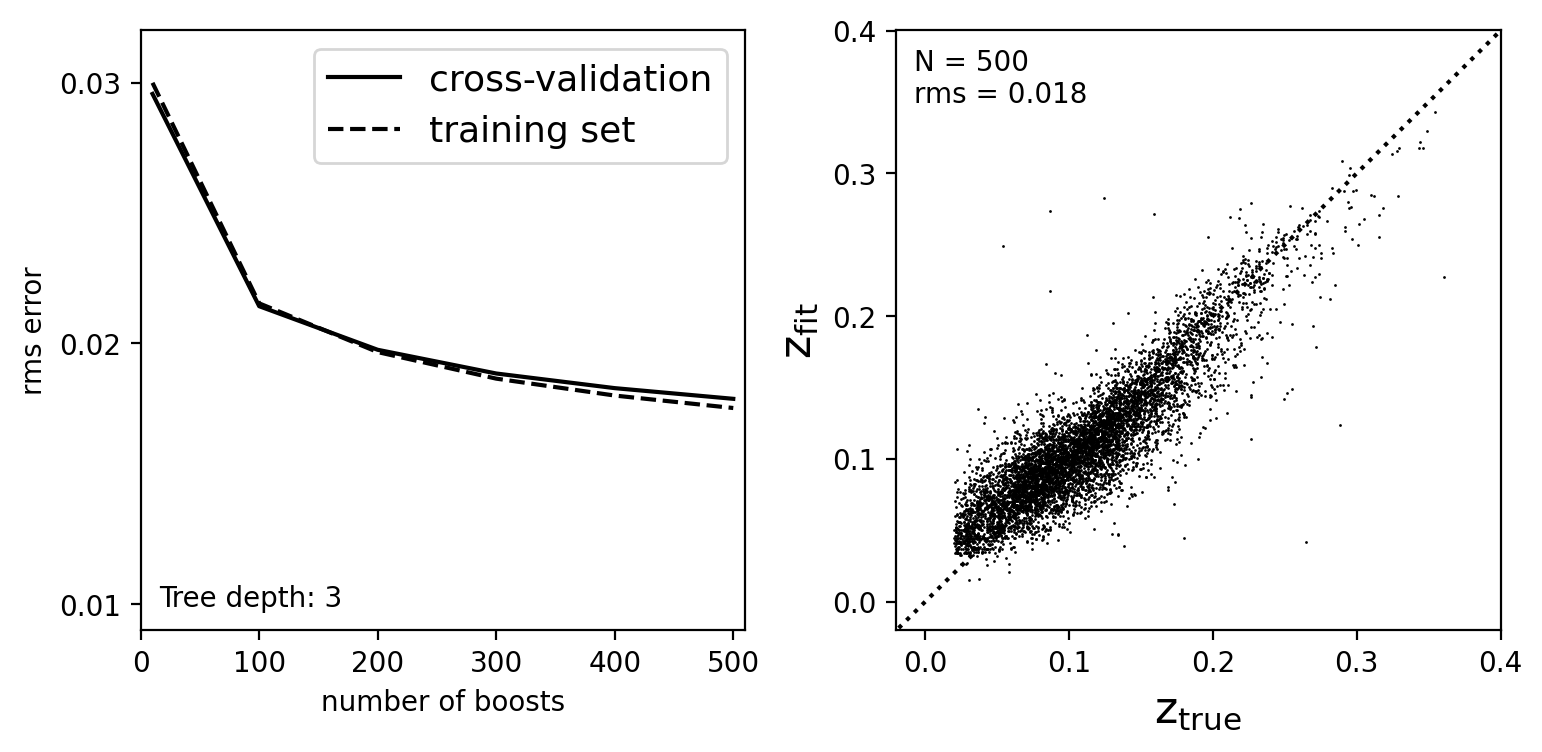

CPU times: user 2.15 s, sys: 328 ms, total: 2.48 s
Wall time: 1.95 s


In [7]:
%%time

import numpy as np
from matplotlib import pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from astroML.datasets import fetch_sdss_specgals
from astroML.decorators import pickle_results

#------------------------------------------------------------
# Fetch and prepare the data
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

# test on ~6,000 distinct points
mag_test = mag[1::100]
z_test = z[1::100]


#------------------------------------------------------------
# Compute the results
#  This is a long computation, so we'll save the results to a pickle.
@pickle_results('photoz_boosting.pkl')
def compute_photoz_forest(N_boosts):
    rms_test = np.zeros(len(N_boosts))
    rms_train = np.zeros(len(N_boosts))
    i_best = 0
    z_fit_best = None

    for i, Nb in enumerate(N_boosts):
        clf = GradientBoostingRegressor(n_estimators=Nb, learning_rate=0.1,
                                        max_depth=3, random_state=0)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit

    return rms_test, rms_train, i_best, z_fit_best

N_boosts = (10, 100, 200, 300, 400, 500)
rms_test, rms_train, i_best, z_fit_best = compute_photoz_forest(N_boosts)
best_N = N_boosts[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(N_boosts, rms_test, '-k', label='cross-validation')
ax.plot(N_boosts, rms_train, '--k', label='training set')
ax.legend(loc=1, prop=dict(size=13))

ax.set_xlabel('number of boosts')
ax.set_ylabel('rms error')
ax.set_xlim(0, 510)
ax.set_ylim(0.009,  0.032)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

ax.text(0.03, 0.03, "Tree depth: 3",
        ha='left', va='bottom', transform=ax.transAxes)

# right panel: plot best fit
ax = fig.add_subplot(122)
ax.scatter(z_test, z_fit_best, s=1, lw=0, c='k')
ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.03, 0.97, "N = %i\nrms = %.3f" % (best_N, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$\rm z_{true}$', fontsize=16)
ax.set_ylabel(r'$\rm z_{fit}$', fontsize=16)

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()

# Unsupervised learning with trees: Isolation forest

Decision trees are an effective tool for exploring the feature space, but can they be used to learn about the distribution of features themselves?

While decision trees rely on split criteria for growth, all of the criteria we have encountered thus far require labeled data. **What can we do if no labels are available?**

### Split randomly!

![Das+2017](itree_das2017.png)

### Ensemble of isolation trees

The iTree algorithm, developed by Liu et al. in 2008, randomly selects a feature and split point within the range of the current data subset during each iteration.

The algorithm stops splitting when it isolates a single sample or reaches the maximum depth, which is usually set to $\log_2 N$.

The Isolation Forest is an ensemble of iTrees, with each individual tree typically built on a small subset of the data, containing around 64-1024 data samples.

![pruzhinakaya+2019](iforest_pruzhinskaya.png)

### How do we score anomalies?

Let's say that initially the feature volume is $V = \prod_j (\max(x_j) - \min(x_j))$ - a volume of a hyper-parallelepiped containing the data set.

In average, each split cuts the feature space by half, so if iTree isolates a sample $x$ in a leaf at depth $d(x)$, this leaf would roughly represent volume of $2^{-d(x)} \times V$.

This makes the iTree to be a **kernel density estimator**, it splits the space into hyper-parallelepipeds and gives probability density for each of the leaves. This probability is proportional to the density and inverse to the volume:

\begin{equation}
\large
p_{iTree}(x) \sim 2^{d(x)}
\end{equation}

Intuitively, an anomaly is a sample located in a very **sparse part of the parameter space**. In other words, it is an **out-of-distribution** sample, an object having a small probability to be sampled from the distribution.

Following the ideas of the original Isolation Forest papers, we can define the probability density of the forest as the probability density of the joint iTree distribution, assuming that all iTrees are independent (since each of them is trained on a small portion of data):

\begin{equation}
\large
p_\mathrm{iso.~forest}(x) = \prod_{t=1}^{T} p_{t\mathrm{-th~iTree}}(x) \sim 2^{\sum_{t=1}^{T} d_t(x)} \sim 2^{\overline{d(x)}}
\end{equation}

For convenience, the anomaly score is defined as the inverse of the probability density, and it is normalized in a way making it between zero and one (usually normalies are around 0.3-0.4, and anomalies are around 0.6-0.8). Therefore, the closer the score is to one, the more anomalous the object is considered to be.

\begin{equation}
\large
\mathrm{Score}(x) \sim 2^{-\overline{d(x)}}, \mathrm{Score} \in (0, 1)
\end{equation}

![Liu+2012](iforest_liu2012.png)

In [8]:
# RUN THIS

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import QuantileTransformer

def anomaly_pipeline(X, true_anomaly=None, top_n=100):
    X = QuantileTransformer(output_distribution='uniform', random_state=0).fit_transform(X)

    X_2d = PCA(n_components=2, random_state=0).fit_transform(X)

    isoforest = IsolationForest(n_estimators=1000, max_samples=64, random_state=0)
    isoforest.fit(X)
    anomaly_scores = isoforest.score_samples(X)
    idx_by_score = np.argsort(anomaly_scores)

    # Plot
    plt.scatter(*X_2d.T, s=0.1, alpha=0.1, color='k', label='data')
    plt.scatter(*X_2d[idx_by_score[:top_n]].T, s=3, color='r', label='pred anomalies')
    if true_anomaly is not None:
        plt.scatter(*X_2d[true_anomaly].T, s=1, color='b', label='true anomalies')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend()
    
    return idx_by_score

# Detect anomalies in Cardiotocography dataset

array([1094,  485, 1095, ...,  931,  739,  930])

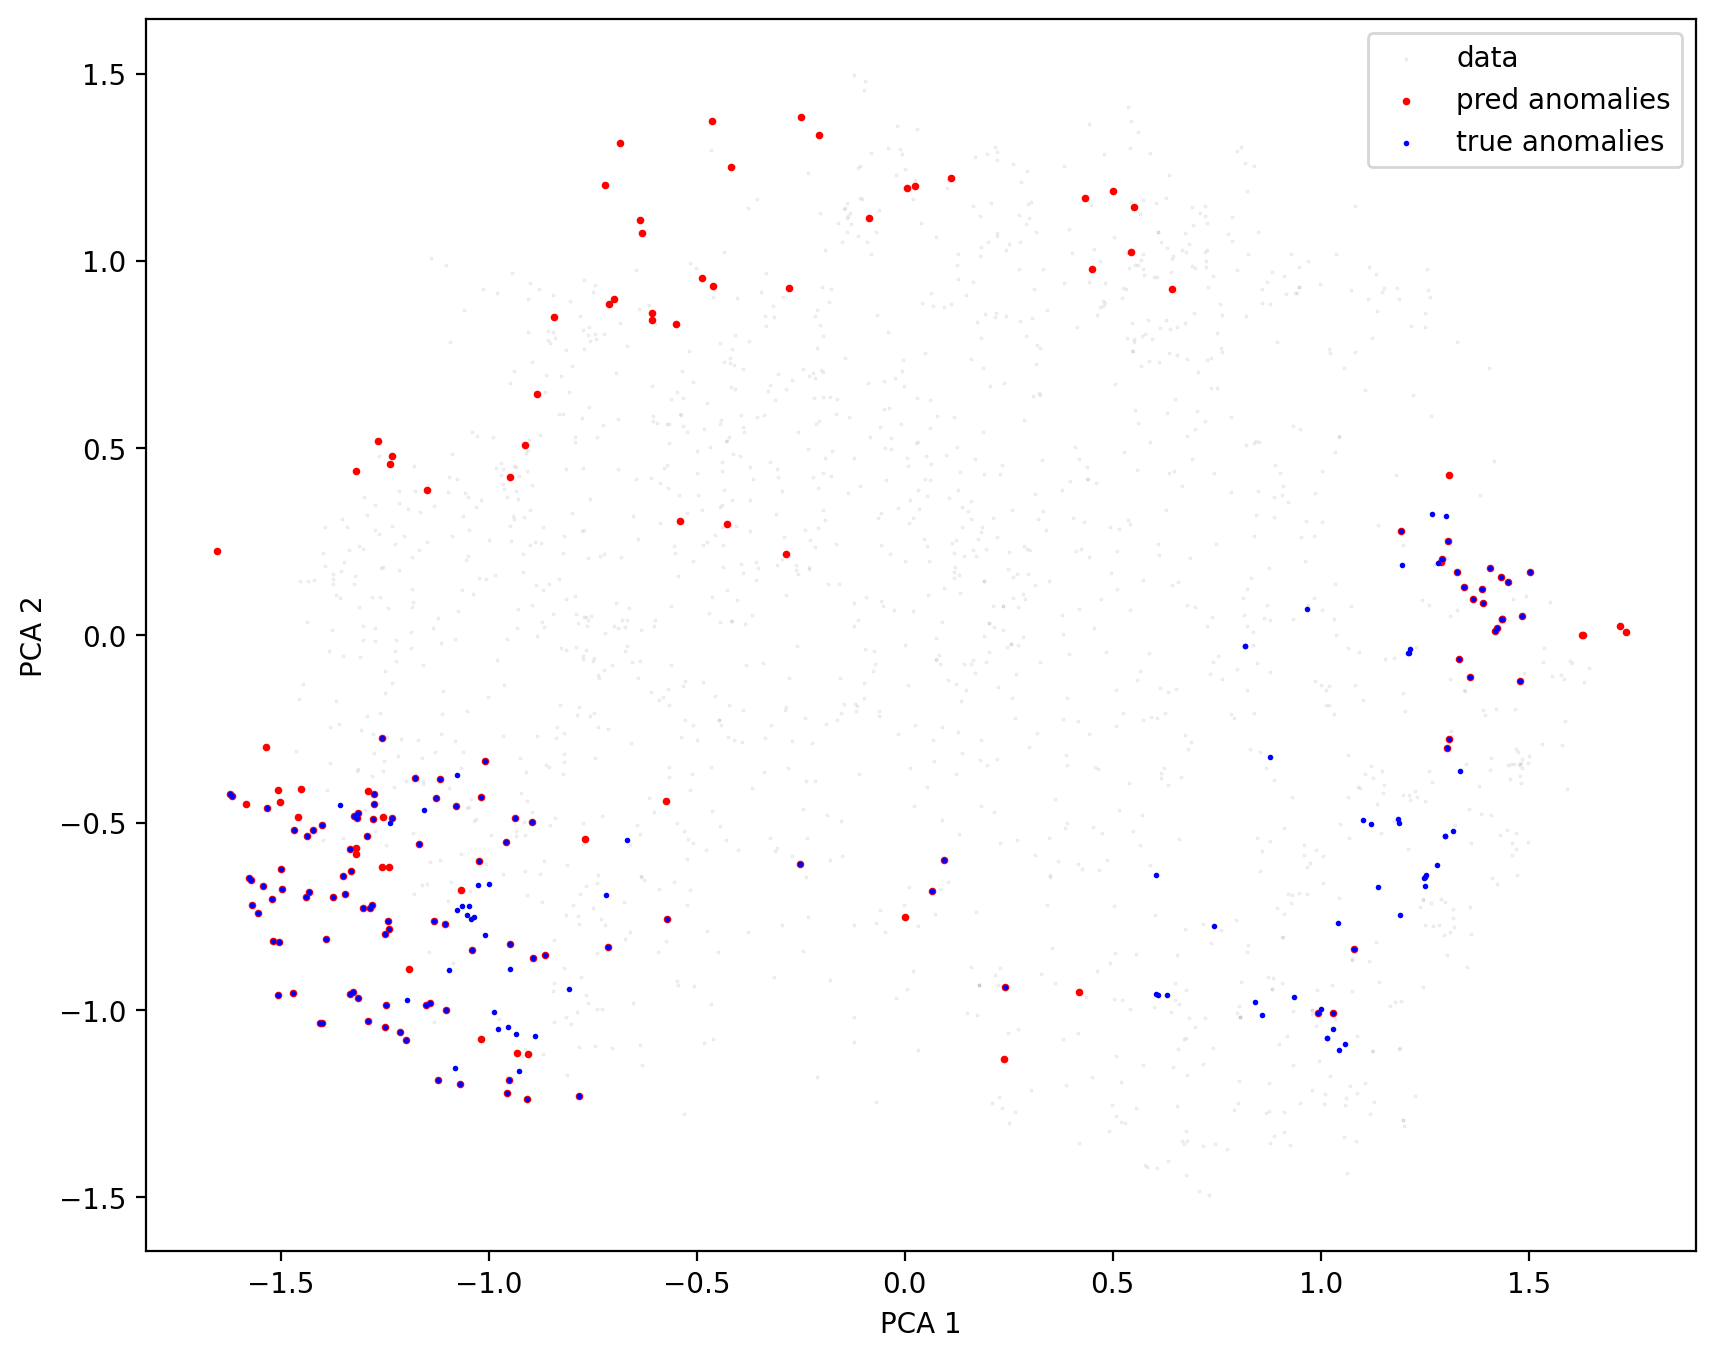

In [9]:
# RUN THIS

from sklearn.datasets import fetch_openml

cardiotocography = fetch_openml('cardiotocography', version=2, parser='auto')
y = cardiotocography['target'].astype('int')
# 1 - normal, 3 - pathalogical
idx = y.isin([1, 3])
y = y[idx]
X = cardiotocography['data'][idx]

anomaly_pipeline(X, true_anomaly=y == 3, top_n=np.sum(y == 3))

# Detect anomalous light curves in M31 ZTF field

https://ztf.snad.space/dr3/view/695211200020939
https://ztf.snad.space/dr3/view/695211200008024
https://ztf.snad.space/dr3/view/695211400126897
https://ztf.snad.space/dr3/view/695211200009221
https://ztf.snad.space/dr3/view/695211200035023
CPU times: user 42.6 s, sys: 7.25 s, total: 49.8 s
Wall time: 12.4 s


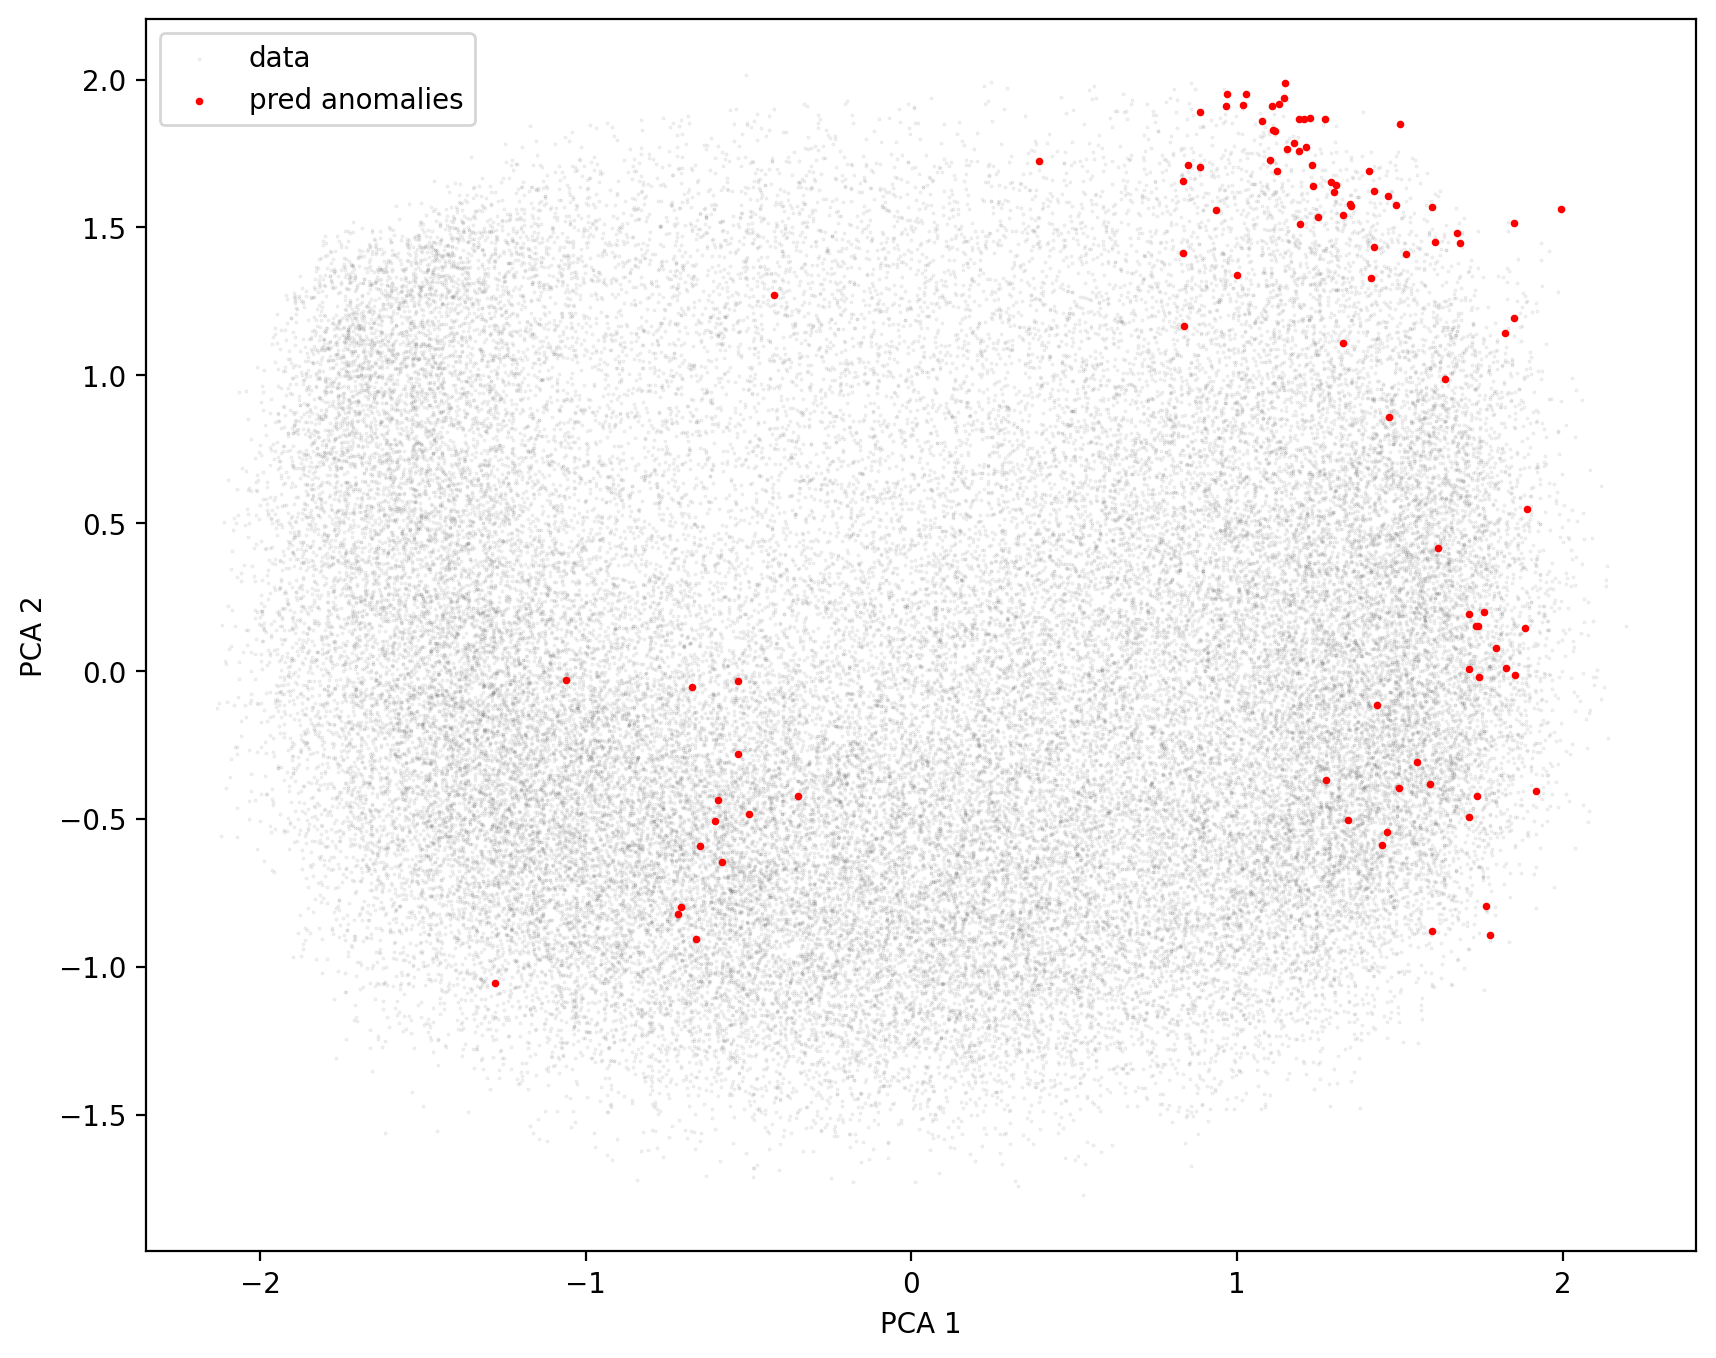

In [10]:
%%time

# RUN THIS

# Get data
with np.load('m31.npz') as archive:
    oid = archive['oid']
    X = archive['feature']
    
idx_by_score = anomaly_pipeline(X, top_n=100)

# Get links to top 5 anomalies
for object_id in oid[idx_by_score[:5]]:
    print(f'https://ztf.snad.space/dr3/view/{object_id}')

# Supervised vs Unsupervised trees

Can we use random splits for supervised learning?..

Yes, we can! But, but using completely random splits comes with certain drawbacks. Random splits do not take into account any underlying patterns or structures in the data, and thus may lead to suboptimal results, even with more complex models such as deep trees and forests.

Furthermore, it is important to note that in supervised learning, we do not directly use feature values, but rather their ordering. This means that **supervised trees are not sensitive to monotonic transformations of individual features**, which is a significant advantage over other popular machine learning algorithms.

# The first step to neural networks: Linear Regression

\begin{equation}
\large
f(x) = \sum_j w_j x_j + c
\end{equation}

### MSE loss makes it to be the ordinal linear least sqaures problem

\begin{equation}
\large
\min_{\theta=\{w_j,c\}} \sum_i \left[y_i - \left(\sum_j w_j x_{ij} + c\right)\right]^2
\end{equation}

Do $\partial / \partial w_i = 0, \partial / \partial c = 0$ and you have the (analytical) solution!

### Regression

![](tf_linear_regression_good.png)

[TF playground](http://playground.tensorflow.org/#activation=sigmoid&batchSize=5&dataset=gauss&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.65532&showTestData=false&discretize=true&percTrainData=40&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=regression&initZero=false&hideText=false)

### Classification

Actualy it is also regression, but the real output value is converted to a binary label.
However, if we'd like to have outputs to be between 0 and 1 we need some normalisation, for example logistic function $\sigma(z) = 1 / (1 + \exp{-z})$.
In this case the model is called logistic regression.

![](tf_linear_regression_clf_good.png)

[TF playground](http://playground.tensorflow.org/#activation=sigmoid&batchSize=5&dataset=gauss&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.73566&showTestData=false&discretize=true&percTrainData=40&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

### But what if the problem is not linear...

![](tf_linear_regression_clf_bad.png)

[TF playground](http://playground.tensorflow.org/#activation=sigmoid&batchSize=5&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.12820&showTestData=false&discretize=true&percTrainData=40&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

### Sometimes we can solve it with a bit of feature engineering

![](tf_linear_regression_engineering.png)

[TF playground](http://playground.tensorflow.org/#activation=sigmoid&batchSize=5&dataset=circle&regDataset=reg-gauss&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2&seed=0.17882&showTestData=false&discretize=true&percTrainData=40&x=false&y=false&xTimesY=false&xSquared=true&ySquared=true&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&numHiddenLayers_hide=false)

# Making the model non-linear

\begin{eqnarray}
&\large h_1(x) = g\left(\sum_j w^{\{1\}}_j x + c^{\{1\}}\right), \\
&\large h_2(x) = g\left(\sum_j w^{\{2\}}_j x + c^{\{2\}}\right), \\
&\large h_3(x) = g\left(\sum_j w^{\{3\}}_j x + c^{\{3\}}\right), \\
&\large f(x) = w_{h1} h_1(x) + w_{h2} h_2(x) + w_{h3} h_3(x) + c_{h},
\end{eqnarray}

where $g$ is some (non-linear) scalar function, same for all transformations. Note that "weights" $w$ and "biases" (or, if we'd write minus instead of plus, "thresholds") $c$ are different for each transformation.

![](tf_slp3.png)

[TF playground](http://playground.tensorflow.org/#activation=sigmoid&batchSize=5&dataset=circle&regDataset=reg-gauss&learningRate=0.03&regularizationRate=0&noise=0&networkShape=3&seed=0.17882&showTestData=false&discretize=true&percTrainData=40&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&numHiddenLayers_hide=false)

### Can we make it better? Easy!

It has $2 \times 8 + 8 \times 1 = 24$ weights.

![](tf_slp8.png)

[TF playground](http://playground.tensorflow.org/#activation=sigmoid&batchSize=5&dataset=circle&regDataset=reg-gauss&learningRate=0.03&regularizationRate=0&noise=0&networkShape=8&seed=0.17882&showTestData=false&discretize=true&percTrainData=40&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&numHiddenLayers_hide=false)

### Mark 1, 1960, Cornell Aeronautical Laboratory

![](mark1.jpg)

# Why does it work?

### Universal approximation theorem

In 1989, George Cybenko proved that for neural networks with a single hidden layer and logistic activation function, the network can approximate any continuous function to arbitrary precision. In 1991 Kurt Hornik shown it for other activation function.

This is the case of "arbitrary width" theorem, we have a single hidden layer, the larger the layer the better the precision.

# Multi-layer perceptron = dense neural network

In practice, single layer is not sufficient, we need huge neuron to solve real world problems.

We can easialy add layers feeding the next perceptron to the output of the previous one.

![](tf_mlp_relu.png)
[TF Playground](http://playground.tensorflow.org/#activation=relu&regularization=L2&batchSize=5&dataset=circle&regDataset=reg-gauss&learningRate=0.001&regularizationRate=0.001&noise=0&networkShape=3,3,3,3,3,3&seed=0.95354&showTestData=false&discretize=true&percTrainData=40&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&numHiddenLayers_hide=false)

Multi-layer neural network is covered by "arbitrary depth" universal approximation theorem, which is proven for some specific cases.

### Fit spiral dataset yourself: [TF playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.04277&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)


### My solution:
![](tf_mlp_relu_spiral.png)
[TF playground](http://playground.tensorflow.org/#activation=relu&regularization=L2&batchSize=5&dataset=spiral&regDataset=reg-gauss&learningRate=0.001&regularizationRate=0.001&noise=0&networkShape=4,4,4,4,4,4&seed=0.75252&showTestData=false&discretize=true&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&numHiddenLayers_hide=false)

https://askabiologist.asu.edu/neuron-anatomy
![](neurons.png)

# How do we train neural networks? Backpropagation

We have what nature has not: calculus!
[(No.)](https://www.nature.com/articles/s41583-020-0277-3)
This allows us to find gradients of the loss function with respect to weights and update weights accordingly for each new sample:

\begin{equation}
\large
w_k \leftarrow w_k + r \left(\frac{\partial l(x_i, y_i)}{\partial w_k}\right)^{-1},
\end{equation}
where $w_k$ is some weight, $l(x_i, y_i)$ is the loss function for the i-th sample, and $r$ is the learning rate, higher learning rate provide larger, but more chaotic changes.

In practice, the simple gradient descent approach is rarely used because it can result in large and chaotic weight value updates. Instead, stochastic gradient optimizers are commonly employed, such as [Adam](https://arxiv.org/abs/1412.6980).

Furthermore, one-by-one sample feeding is the extreme case, in contrast to "normal" least squares optimization, where all samples are used simultaneously. In general, samples are grouped into batches to be fed into a neural network. The batch size is chosen as a trade-off between training speed, memory usage, and final model quality.

![](backprop.png)

https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/

# Why neural networks?

- Great flexibility: we can use NNs with images, sound, text, time series, probability distributions, etc.
- Combination of linear algebra and scalar functions allow fast training and evaluation on GPUs and special processor units such as tensor PUs, neural PUs or even field-programmable gate arrays.
- Re-usability: you can take someone else's architecture and train the network for your data, or you can even get someone else's weights and fine-tune it.

![](nn.webp)
https://towardsdatascience.com/the-mostly-complete-chart-of-neural-networks-explained-3fb6f2367464